Apply target encoding to fetures in the Ames dataset

In [3]:
#import essential libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

#set matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes',
      labelweight='bold',
      labelsize='large',
      titleweight='bold',
      titlesize=14,
      titlepad=10,)

warnings.filterwarnings('ignore')

#define model scoring
def score_dataset(X, y, model=XGBRegressor()):
    #Label encoding for categoricals
    for colname in X.select_dtypes(['category', 'object']):
        X[colname], _ = X[colname].factorize()
    #Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(model,
                            X, y, cv=5, scoring='neg_mean_squared_log_error')
        
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

df = pd.read_csv('./data/house-prices-advanced-regression-techniques/ames.csv')

In [4]:
#see all categorical features, and chose the one with large number of categories are often good candidates
df.select_dtypes(['object']).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       6
SaleType         10
SaleCondition     6
dtype: int64

We need to consider the M-estimate encoding used to smoothing to improve estimates for rare categories. using value_counts to see how many time a category occurs in the dataset

In [6]:
#As seen in the above section, we will work on Neighborhood features with largest number of categories
df['Neighborhood'].value_counts()

North_Ames                                 443
College_Creek                              267
Old_Town                                   239
Edwards                                    194
Somerset                                   182
Northridge_Heights                         166
Gilbert                                    165
Sawyer                                     151
Northwest_Ames                             131
Sawyer_West                                125
Mitchell                                   114
Brookside                                  108
Crawford                                   103
Iowa_DOT_and_Rail_Road                      93
Timberland                                  72
Northridge                                  71
Stone_Brook                                 51
South_and_West_of_Iowa_State_University     48
Clear_Creek                                 44
Meadow_Village                              37
Briardale                                   30
Bloomington_H

Others are worth to be considered are SaleType, MSSubClass, EXterior1st, Exterior2nd. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.

### NOTE:
To avoid overfitting, We need to fit the encoder on data heldout from the training set

In [7]:
#encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop('SalePrice')

#training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop('SalePrice')

In [10]:
#create encoder instance
encoder = MEstimateEncoder(cols=['Neighborhood'], m=5.0)

#fit the encoder on encoding split
encoder.fit(X_encode, y_encode)

#encode the Nieghborhood column in training split
X_train = encoder.transform(X_pretrain, y_train)

Text(0.5, 0, 'SalePrice')

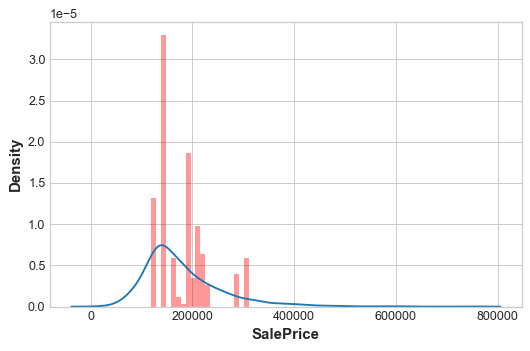

In [12]:
#see how our encoded feature compares to the target
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel('SalePrice')

It seems distribution of encoded feature does not significantly follow the distribution of the actual target SalePrice, let's how it's score compares to original dataset


In [13]:
X = df.copy()
y = X.pop('SalePrice')
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with target encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1428 RMSLE
Score with target encoding: 0.1383 RMSLE


Even the distribution of encoded feature does not significantly follow the distribution of the actual target SalePrice, but it still makes good impact on scoring, proving that they are informative and worthwhile in this case

#### example of overfitting with target encodings happened if we dont heldout from training set

In [ ]:
#experimemting with the smoothing param m, 0, 1, 5, 50
m = 0

X = df.copy()
y = X.pop('SalePrice')

#Create an uniformative feature
X['Count'] = range(len(X))
X['Count']